In [ ]:
from utils.llm_connector import LLM_Connector
from utils.interactive_retrieval_model import InteractiveRetrievalModel
import utils.config as config
import os

class InteractiveRetrievalDemo:
    
    # LLM Connector configuration
    LLM_API_KEY = config.LLM_API_KEY
    LLM_BASE_URL = config.LLM_BASE_URL
    LLM_MODEL_NAME = config.LLM_MODEL_NAME

    # Corpus path
    IMG_ROOT_PATH = config.IMG_ROOT_PATH
    # Corpus embedding root path
    IMG_EMBEDDING_ROOT_PATH = config.IMG_EMBEDDING_ROOT_PATH

    MEMORY_STORAGE = {}
    
    def __init__(self):
        self.initialize_models_and_data()

    def initialize_models_and_data(self):
        print('\n' + "-" * 30 + "Initializing models and data..." + "-" * 30)
        self.llm_connector_instance = LLM_Connector(api_key=self.LLM_API_KEY, 
                                               base_url=self.LLM_BASE_URL, 
                                               model_name=self.LLM_MODEL_NAME)
        self.interactive_retrieval_model = InteractiveRetrievalModel(self.IMG_ROOT_PATH, self.IMG_EMBEDDING_ROOT_PATH, model_name='BLIP')
        
        self.img_id_2_name = {} # id to name
        for name in os.listdir(config.IMG_ROOT_PATH):
            img_id = name.split('.')[0]
            self.img_id_2_name[img_id] = name
        
    def retrieve(self, query):
        retrieved_images_and_captions = self.interactive_retrieval_model.retrieval_context_extraction(query)
        
        self.MEMORY_STORAGE['retrieved_images_and_captions'] = retrieved_images_and_captions
        
        print("Retrieval Context (Captions):")
        # for img_id, caption in retrieved_images_and_captions.items():
        #     print(f'Image ID: {img_id}   Caption: {caption}')
        
        self.show_retrieved_results(retrieved_images_and_captions)
            
        return retrieved_images_and_captions
    
    def questioner_and_filtering(self, round):
        print('\n' + "-" * 30 + f"Round {round} (Generate LLM question)" + "-" * 30)
        new_questions = self.llm_connector_instance.questioner(self.MEMORY_STORAGE['retrieved_images_and_captions'],
                                                                    self.MEMORY_STORAGE['initial_query'],
                                                                    self.MEMORY_STORAGE['dialogues'])
        
        print("+ Generated LLM question:")
        for i, question in enumerate(new_questions):
            print(f"{i}. {question}")
        
        invalid_questions, valid_questions = self.llm_connector_instance.filtering(new_questions=new_questions,
                                                                              initial_description=self.MEMORY_STORAGE['initial_query'],
                                                                              dialogues=self.MEMORY_STORAGE['dialogues'])
        
        print("+ Valid questions:")
        for i, question in enumerate(valid_questions):
            print(f"{i}. {question}")
            
        print("+ Invalid questions:")
        for i, question in enumerate(invalid_questions):
            print(f"{i}. {question}")
        
        if not valid_questions:
            print("+ No valid questions generated. Exiting the dialogue.")
            exit()
        
        chosen_question = valid_questions[0]
        
        print(f"+ Chosen question: {chosen_question}")
        
        return chosen_question
    
    def show_retrieved_results(self, retrieved_images_and_captions):
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        import textwrap
            
        # 示例图片路径和描述
        image_ids = [id for id in retrieved_images_and_captions.keys()]
        image_paths = [os.path.join(config.IMG_ROOT_PATH, self.img_id_2_name[id]) for id in image_ids]
        captions = [cap for cap in retrieved_images_and_captions.values()]

        # 设置图像展示的行列数
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))

        # 最大宽度，用于换行处理
        max_line_length = 30  # 你可以调整这个值来控制换行的长度

        # 遍历所有图片并显示
        for i in range(10):
            ax = axes[i // 5, i % 5]  # 根据行列位置获取子图
            img = mpimg.imread(image_paths[i])  # 读取图片
            ax.imshow(img)  # 显示图片
            ax.axis('off')  # 关闭坐标轴

            # 处理长caption，自动换行
            wrapped_caption = textwrap.fill(captions[i], width=max_line_length)

            # 显示Image ID和Caption，并确保它们之间有适当的间距
            ax.text(0.5, -0.1, f"{image_ids[i]}", ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.text(0.5, -0.25, f"\n{wrapped_caption}", ha='center', va='center', transform=ax.transAxes, fontsize=10)

        # 调整布局以避免重叠
        plt.tight_layout()
        plt.show()
            
        return retrieved_images_and_captions

    
    def first_round_retrieval(self):
        print("-" * 30 + "Round 0 (User query)" + "-" * 30)
        initial_query = input("+ Please enter the initial query: ")
        self.MEMORY_STORAGE['initial_query'] = initial_query
        self.MEMORY_STORAGE['last_query'] = initial_query
        self.MEMORY_STORAGE['dialogues'] = []

        print('\n' + "-" * 30 + "Round 0 (Retrieve images)" + "-" * 30)
        self.retrieve(initial_query)
        

    def interactive_retrieval_loop(self):
        chosen_question = self.questioner_and_filtering(round=1)
        
        round = 2
        while True:
            answer = input(f"+ {chosen_question} (\'exit\' to quit):  ")
            
            if answer.lower() == 'exit':
                print("Exiting the dialogue.")
                break
            
            self.MEMORY_STORAGE['dialogues'].append({
                'question': chosen_question,
                'answer': answer
            })
            
            reformulated_query = self.llm_connector_instance.reformulator(self.MEMORY_STORAGE['last_query'],
                                                                            self.MEMORY_STORAGE['dialogues'])
            print("+ Reformulated response:", reformulated_query)
            self.MEMORY_STORAGE['last_query'] = reformulated_query
            
            self.retrieve(reformulated_query)
            
            chosen_question = self.questioner_and_filtering(round=round)
            
            round += 1
    
    def main(self):
        self.first_round_retrieval()
        
        self.interactive_retrieval_loop()
    



------------------------------Initializing models and data...------------------------------
------------------------------Round 0 (User query)------------------------------

------------------------------Round 0 (Retrieve images)------------------------------
Loading image embeddings from /home/chenyang/projects/PlugIR_mine/embeddings/BLIP_VisualDialog_val2018_img_embeddings.json...
Retrieval Context (Captions):


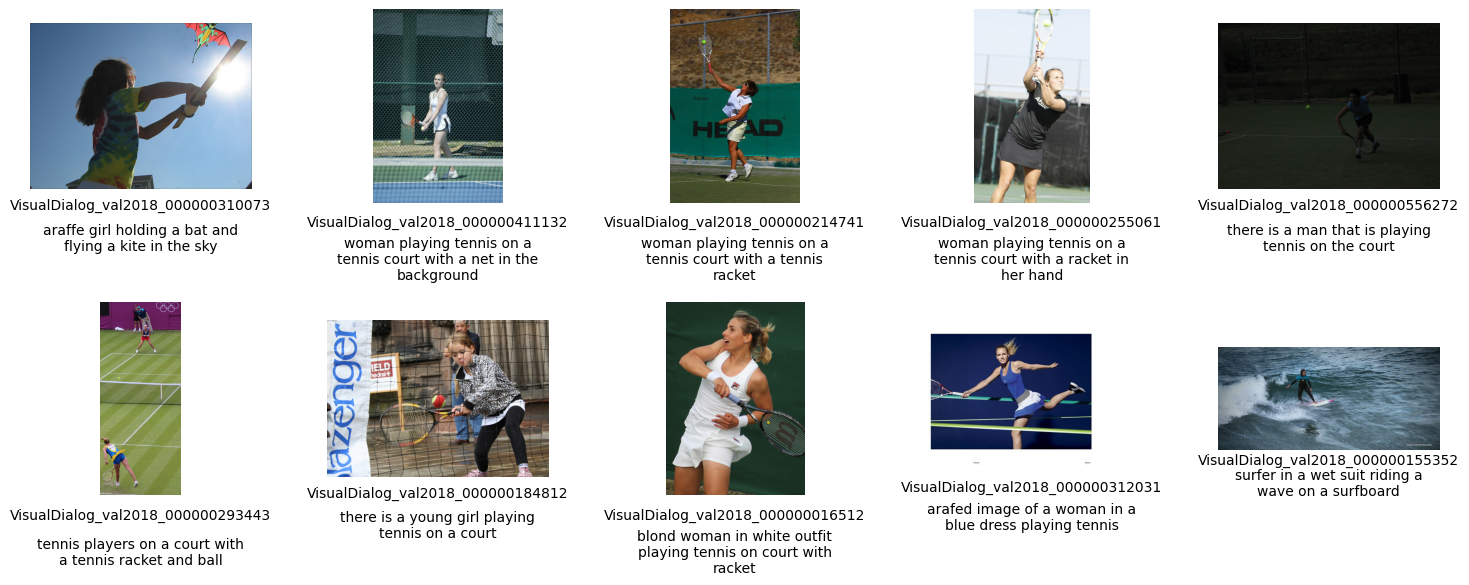


------------------------------Round 1 (Generate LLM question)------------------------------
+ Generated LLM question:
0. What type of tennis court surface is the woman playing on?
1. What type of tennis court surface is the woman playing on?
2. What type of tennis court surface is the woman playing on?
3. What type of tennis court surface is the woman playing on?
4. What type of tennis court is the woman playing on?
+ Valid questions:
0. What type of tennis court surface is the woman playing on?
1. What type of tennis court surface is the woman playing on?
2. What type of tennis court surface is the woman playing on?
+ Invalid questions:
0. What type of tennis court surface is the woman playing on?
1. What type of tennis court is the woman playing on?
+ Chosen question: What type of tennis court surface is the woman playing on?
+ Reformulated response: a woman is playing tennis on a green tennis court surface
Loading image embeddings from /home/chenyang/projects/PlugIR_mine/embeddings

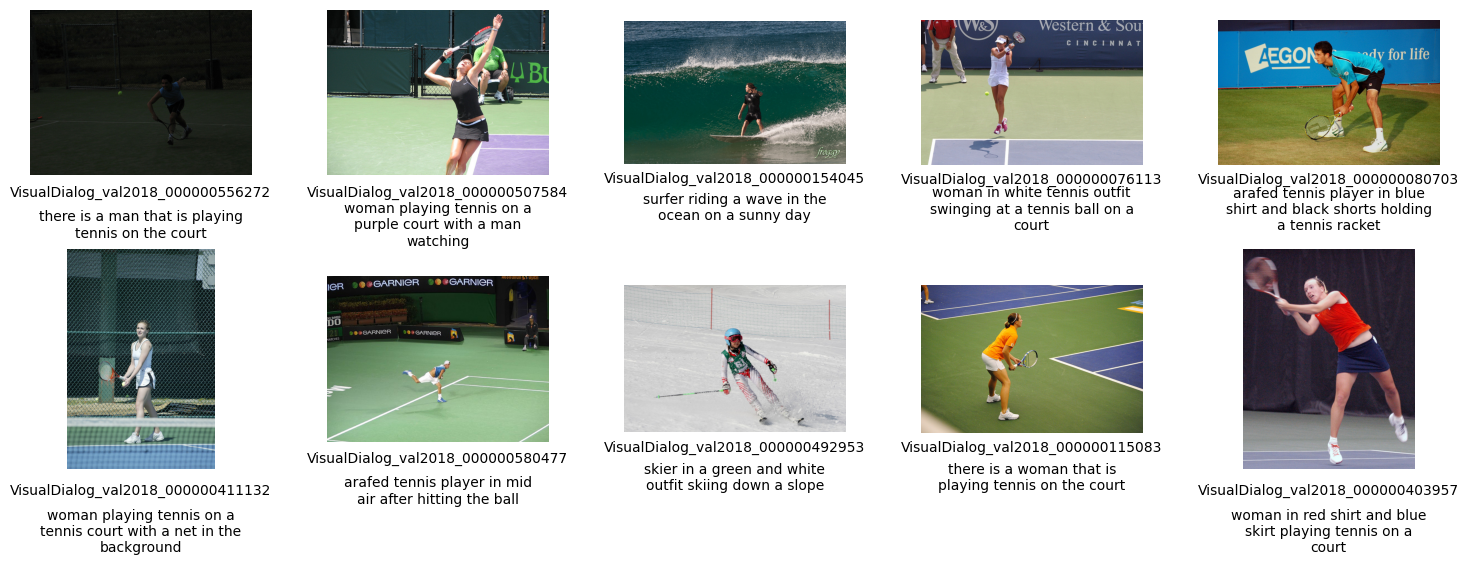


------------------------------Round 2 (Generate LLM question)------------------------------

------------------------------Round 2 (Generate LLM question)------------------------------
+ Generated LLM question:
0. What type of tennis court surface is the woman playing on?
1. What type of tennis court surface is the woman playing on?
2. Is the woman playing singles or doubles tennis?
3. What type of tennis court surface is the woman playing on?
4. Is the woman playing tennis indoors or outdoors?
+ Valid questions:
0. What type of tennis court surface is the woman playing on?
1. What type of tennis court surface is the woman playing on?
2. What type of tennis court surface is the woman playing on?
+ Invalid questions:
0. Is the woman playing singles or doubles tennis?
1. Is the woman playing tennis indoors or outdoors?
+ Chosen question: What type of tennis court surface is the woman playing on?
+ Reformulated response: a woman is playing tennis on a green tennis court surface
Loading i

KeyboardInterrupt: 

In [9]:
if __name__ == "__main__":
    demo = InteractiveRetrievalDemo()
    demo.main()